First, install the dev branch of `gnss_lib_py`. Don't worry if you see an ERROR regarding pip dependencies. That error means we updated colab's versions of some packages and won't affect the colab's runtime performance.

In [ ]:
# install dev branch of gnss_lib_py
import os
os.makedirs("/content/lib", exist_ok=True)
%cd /content/lib
!pip install --upgrade pip --quiet --progress-bar off
!git clone https://github.com/Stanford-NavLab/gnss_lib_py.git --quiet
%cd gnss_lib_py
!git checkout derek/android_raw
!git pull
!pip install -e . --quiet --progress-bar off
%cd /content
import site
site.main()

/content/lib
/content/lib/gnss_lib_py
Branch 'derek/android_raw' set up to track remote branch 'derek/android_raw' from 'origin'.
Switched to a new branch 'derek/android_raw'
Already up to date.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Building editable for gnss-lib-py (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires ipykernel==5.5.6, but you 

# GnssLogger Android App

This tutorial walks through how to parse the files obtained from [Google's

---

GNSSLogger Android App](https://play.google.com/store/apps/details?id=com.google.android.apps.location.gps.gnsslogger&pcampaignid=web_share). Details for each data type can be found in Google's [gps-measurement-tools](https://github.com/google/gps-measurement-tools/blob/master/LOGGING_FORMAT.md) repository.

The toggle switches on the "Home" tab of the GNSSLogger app need to be set based on the type(s) of measurements you want to log: fixes, raw, NMEA, Rinex, sensors, etc.

After data is logged, the measurements can be saved immediately or retrieved at a later time within Android's internal storage. Data can be found on the phone under a directory similar to: ``<phone>/Internal shared storage/Android/data/com.google.android.apps.location.gps.gnsslogger/files/gnss_log/``

## AA272 Tips

*   The SP3 and CLK satellite ephemeris is not usually available until 2-3 days afterwards. So you may need to wait a couple of days before you can add satellite positions with the `add_sv_states()` function and compute a WLS solution. Record early!
*   Some phones may not record data from specific satellite constellations or be able to record rinex or NMEA observations. Try recording at your home/locally before travelling anywhere to troubleshoot potential issues.
*   It's easier to delete unneeded data than repeat experiments, so I'd suggest enabling all toggle switches in the GNSSLogger App so you're recording all possible data types during your experiment.



Load `gnss_lib_py` into the Python workspace

In [ ]:
import numpy as np
import gnss_lib_py as glp
from gnss_lib_py import NavData
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Fix Measurements from gnss_log*.txt

The first type of measurements we can get is toggling a combination of "GNSS Location", "Fused Location", and/or "Network Location" in the GNSSLogger app. These location fixes are indicated with rows that start with "Fix" in the gnss_log.txt file output.

We start by downloading an example measurement file from the GNSSLogger Android App.

Load fix data into the existing `glp.AndroidRawFixes` class.

In [ ]:
path = "drive/MyDrive/AA272/gnss_log_bike.txt"
fix_data = glp.AndroidRawFixes(path)
# print(fix_data)

Based on the toggles you choose in the GNSSLogger app, you may have three different type of fixes: GNSS, network, and fused.

In [ ]:
fix_types = np.unique(fix_data["fix_provider"]).tolist()
fix_types

['fused', 'gnss', 'network']

We will extract these three different type of fixes and rename their row names so that we can plot them as different colors all on the same map.

In [ ]:
fixes = []
for provider in fix_types:
    fix_provider = fix_data.where("fix_provider",provider)
    fix_provider.rename({"lat_rx_deg":"lat_rx_" + provider + "_deg",
                         "lon_rx_deg":"lon_rx_" + provider + "_deg",
                         "alt_rx_m":"alt_rx_" + provider + "_m",
                         }, inplace=True)
    fixes.append(fix_provider)

The GNSS, fused, and network location fixes are all shown in different colors in the map below.

In [ ]:
rains_path = "drive/MyDrive/AA272/rains_boundary.csv"
data = np.genfromtxt(rains_path, delimiter=',')
RainsNavData = NavData(numpy_array=data.T)
RainsNavData.rename({"0" : "lat_Rains_deg","1" : "lon_Rains_deg"},inplace=True)
print(len(RainsNavData))

fig_fix = glp.plot_map(*fixes)
fig_fix.show()

1392


Download example measurement file from the GNSSLogger Android App.

# Project Functions
Adding all functions relevant for project data processing below


## Raw Measurements from gnss_log*.txt

The secibd type of measurements we can get is by toggling "Measurements" in

*   List item
*   List item

the GNSSLogger app. These are raw measurements indicated with rows that start with "Raw" in the gnss_log.txt file output.

We start by loading our previously downloaded raw data into the existing `glp.AndroidRawGNSS` class. When you load the data here, behind the scenes it will compute the raw pseudorange values optionally filter measurements based on a variety of conditions. See the the [filter_raw_measurements](https://gnss-lib-py.readthedocs.io/en/latest/reference/parsers/android.html#android.AndroidRawGnss.filter_raw_measurements) reference documentation for details on the options for exisitng filter types.

In [ ]:
raw_data = glp.AndroidRawGnss(input_path=path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)

sv_time_uncertainty removed 3


In [ ]:
raw_data = raw_data.where("sv_id",2,"neq")  # get rid of satellite G02 to prevent ephemeris error: ('sp3 data does not include appropriate times in measurement file for SV ', 'G02')
# raw_data['sv_id']

In [ ]:
full_states = glp.add_sv_states(raw_data, source="precise", verbose=False)
print(full_states)

      # Raw    unix_millis        TimeNanos  LeapSecond  TimeUncertaintyNanos  \
0       Raw  1701218390999  261608999248946          18                   0.0   
1       Raw  1701218390999  261608999248946          18                   0.0   
2       Raw  1701218390999  261608999248946          18                   0.0   
3       Raw  1701218390999  261608999248946          18                   0.0   
4       Raw  1701218390999  261608999248946          18                   0.0   
...     ...            ...              ...         ...                   ...   
19801   Raw  1701219424000  262642000137936          18                   0.0   
19802   Raw  1701219424000  262642000137936          18                   0.0   
19803   Raw  1701219424000  262642000137936          18                   0.0   
19804   Raw  1701219424000  262642000137936          18                   0.0   
19805   Raw  1701219424000  262642000137936          18                   0.0   

             FullBiasNanos 

In [ ]:
def get_unit_vector(az, el):
    az = az*np.pi/180   #convert to radians
    el = el*np.pi/180   #convert to radians
    unit_vector = np.array([np.sin(az)*np.cos(el), np.cos(az)*np.cos(el), np.sin(el)])
    return unit_vector

In [ ]:
#Helper functions for getSigmaHorizontalSVD
def get_az_el(timestamp):
    # Get satellite azimuth and elevation angles for desired timestamp
    #Receiver lla to ecef positions:
    gnss_dataframe = fixes[1]  # Access gnss type DataFrame from fixes
    x_lla = gnss_dataframe[["lat_rx_gnss_deg", "lon_rx_gnss_deg", "alt_rx_gnss_m"]]
    pos_rx_m = glp.geodetic_to_ecef(x_lla)

    #Choose one receiver ECEF position to use (Note: we just chose to use the first one):
    x_rx_chosen = pos_rx_m[0][0]
    y_rx_chosen = pos_rx_m[1][0]
    z_rx_chosen = pos_rx_m[2][0]
    pos_rx_m_chosen = np.array([x_rx_chosen, y_rx_chosen, z_rx_chosen])
    pos_rx_m_chosen = pos_rx_m_chosen.reshape((3,1))

    #Satellite positions:
    data = full_states.where("unix_millis",timestamp,"eq")
    data = data.where("raw_pr_sigma_m",0,"neq")
    pos_sv_m = data.where("unix_millis",timestamp,"eq")[["x_sv_m","y_sv_m","z_sv_m"]]    #satellite positions at input timestamp

    SV_IDs = data[["gnss_sv_id"]]
    pos_sv_m = np.array(pos_sv_m)
    x_sv_m = pos_sv_m[0]
    y_sv_m = pos_sv_m[1]
    z_sv_m = pos_sv_m[2]
    #Remove nan values:
    x_sv_m = x_sv_m[~np.isnan(x_sv_m)]
    y_sv_m = y_sv_m[~np.isnan(y_sv_m)]
    z_sv_m = z_sv_m[~np.isnan(z_sv_m)]
    pos_sv_m = np.array([x_sv_m, y_sv_m, z_sv_m])

    #Calculate el, az using satellite and chosen receiver positions:
    calculated_el_az = glp.ecef_to_el_az(pos_rx_m_chosen,pos_sv_m)
    els = calculated_el_az[0]   #elevation angles (degrees) for each satellite
    azs = calculated_el_az[1]   #azimuth angles (degrees) for each satellite)
    return els, azs

def get_G(timestamp):
    el_arr, az_arr = get_az_el(timestamp)
    # print(len(el_arr))
    for i in range(len(az_arr)):
        unit_vec = get_unit_vector(az_arr[i], el_arr[i])
        new_row = np.zeros(4)
        new_row[:3] = unit_vec
        new_row[3] = 1
        if i == 0:
            G = new_row
        else:
            G = np.vstack((G, new_row))
    return G

In [ ]:
#test the above helper ftns
# timestamp1 = 1701218390999
# timestamp2 = 1701219424000
# timestamps = full_states[["unix_millis"]]
# for timestamp in timestamps:
#     G = get_G(timestamp)

In [ ]:
def compute_dop_matrix(az_arr, el_arr):
    for i in range(len(az_arr)):
        unit_vec = get_unit_vector(az_arr[i], el_arr[i])
        new_row = np.zeros(4)
        new_row[:3] = unit_vec
        # print(unit_vec)
        new_row[3] = 1
        if i == 0:
            G = new_row
        else:
            G = np.vstack((G, new_row))
    H = np.linalg.inv(G.T@G)
    return H, G

In [ ]:
def compute_hdop(H):
    HDOP = np.sqrt(H[0,0] + H[1,1])
    return HDOP

In [ ]:
def closest_point(rains_point, fix_data):
  fix_data_gnss = fix_data.where('fix_provider','gnss')
  data_lat_lon = fix_data_gnss['lat_rx_deg', 'lon_rx_deg']
  min_idx = np.argmin(np.linalg.norm(data_lat_lon - rains_point.reshape(-1, 1), axis=0))
  return fix_data_gnss['unix_millis'][min_idx]

In [ ]:
def getSigmaHorizontal(data,timestamp,HDOP):
    # timestamp unix_millis
    closest_timestamp = raw_data["unix_millis"][np.argmin(abs(timestamp-data["unix_millis"]))]
    # print(closest_timestamp)
    data_timestamp = data.where("unix_millis",closest_timestamp)
    data_timestamp = data_timestamp.where("raw_pr_sigma_m",0,"neq")
    sigma_URE_est = np.mean(data_timestamp["raw_pr_sigma_m"])
    # sigma_URE_est = np.median(data_timestamp["raw_pr_sigma_m"][data_timestamp["raw_pr_sigma_m"] != 0])
    # print(sigma_URE_est)
    G = get_G(closest_timestamp)
    H = np.linalg.inv(G.T@G)
    HDOP = compute_hdop(H)
    sigma_horizontal = sigma_URE_est*HDOP
    return sigma_horizontal
def getSigmaHorizontalSVD(data,timestamp,Gold,SV_IDs):
    # timestamp unix_millis
    closest_timestamp = raw_data["unix_millis"][np.argmin(abs(timestamp-data["unix_millis"]))]
    data_timestamp = data.where("unix_millis",closest_timestamp)
    data_timestamp = data_timestamp.where("raw_pr_sigma_m",0,"neq")
    sigma_URE = data_timestamp["raw_pr_sigma_m"]
    G = get_G(closest_timestamp)
    W = np.diag(1/sigma_URE**2)
    cov = np.linalg.inv(G.T@W@G)[:2,:2]
    U,S,VT = np.linalg.svd(cov)
    sigma_horizontal = max(S)
    return sigma_horizontal


In [ ]:
def computeBoundary(rains_lat_lon, sigma_horizontal,n_sigma=3):
    n = len(rains_lat_lon)
    boundary_lat_lon = np.zeros((n,2))
    for i in range(n):
        delta_lat_lon = rains_lat_lon[i] - rains_lat_lon[i-1]
        vec = np.cross(np.concatenate((delta_lat_lon,np.array([0]))),np.array([0.,0.,1.]))[:2]
        u_vec = vec/np.linalg.norm(vec)
        boundary_lat_lon[i] = n_sigma * sigma_horizontal[i] * u_vec
        boundary_lat_lon[i][0] *= 0.00001
        boundary_lat_lon[i][1] *= 0.00001 / np.cos(rains_lat_lon[i][0])
        boundary_lat_lon[i] += rains_lat_lon[i]
    return boundary_lat_lon
# rains_data = np.array(data)
# boundary_data = computeBoundary(rains_data, 5.*np.ones(len(rains_data)))



HDOP

In [ ]:
#Receiver lla to ecef positions
gnss_dataframe = fixes[1]  # Access gnss DataFrame
x_lla = gnss_dataframe[["lat_rx_gnss_deg", "lon_rx_gnss_deg", "alt_rx_gnss_m"]]     # Access gnss type DataFrame from fixes
pos_rx_m = glp.geodetic_to_ecef(x_lla)

#Choose one receiver ECEF position to use (just took first one)
x_rx_chosen = pos_rx_m[0][0]
y_rx_chosen = pos_rx_m[1][0]
z_rx_chosen = pos_rx_m[2][0]
pos_rx_m_chosen = np.array([x_rx_chosen, y_rx_chosen, z_rx_chosen])
pos_rx_m_chosen = pos_rx_m_chosen.reshape((3,1))

#Satellite positions
pos_sv_m = full_states.where("TimeNanos",261608999248946)[["x_sv_m","y_sv_m","z_sv_m"]]
SV_IDs = full_states.where("TimeNanos",261608999248946)[["gnss_sv_id"]]
pos_sv_m = np.array(pos_sv_m)
x_sv_m = pos_sv_m[0]
y_sv_m = pos_sv_m[1]
z_sv_m = pos_sv_m[2]
x_sv_m = x_sv_m[~np.isnan(x_sv_m)]
y_sv_m = y_sv_m[~np.isnan(y_sv_m)]
z_sv_m = z_sv_m[~np.isnan(z_sv_m)]
pos_sv_m = np.array([x_sv_m, y_sv_m, z_sv_m])

#Calculate el, az using satellite and chosen receiver positions
calculated_el_az = glp.ecef_to_el_az(pos_rx_m_chosen,pos_sv_m)
els = calculated_el_az[0]   #elevation angles (degrees) for each satellite
azs = calculated_el_az[1]   #azimuth angles (degrees) for each satellite)


In [ ]:
H, G = compute_dop_matrix(azs, els)
print(H)
print('')
HDOP = compute_hdop(H)
print(HDOP)
print('')
print(G)


[[ 0.46047767  0.19980667  0.21128293 -0.16921823]
 [ 0.19980667  0.72122721  0.12679516 -0.08206199]
 [ 0.21128293  0.12679516  2.03234839 -1.4145716 ]
 [-0.16921823 -0.08206199 -1.4145716   1.09719747]]

1.0870625034040358

[[-0.70808693  0.61147371  0.353147    1.        ]
 [-0.56854324  0.1913674   0.80008569  1.        ]
 [ 0.04031822  0.33992168  0.93958911  1.        ]
 [-0.29404163  0.20512062  0.93352292  1.        ]
 [ 0.40624018 -0.03302265  0.91316944  1.        ]
 [ 0.1061794  -0.4992149   0.85994792  1.        ]
 [-0.1476326  -0.81919808  0.5541833   1.        ]
 [ 0.76076498 -0.29576817  0.57771778  1.        ]
 [ 0.95399301  0.07752278  0.28963349  1.        ]]


In [ ]:
sigma_h = np.zeros(len(data))
for i in range(len(data)):
    timestamp = closest_point(data[i],fix_data)
    sigma_h[i] = getSigmaHorizontal(raw_data,timestamp,HDOP)
    # sigma_h[i] = getSigmaHorizontalSVD(full_states,timestamp,G,SV_IDs)

boundary_data = computeBoundary(data,sigma_h)
RainsBoundaryNavData = NavData(numpy_array=boundary_data.T)
RainsBoundaryNavData.rename({"0" : "lat_Rains_Boundary_deg","1" : "lon_Rains_Boundary_deg"},inplace=True)
# print(sigma_h)

In [ ]:
#HDOP results (for now, unless someone else reruns stuff)
test_path = "drive/MyDrive/AA272/gnss_log_bike.txt"
test_data = glp.AndroidRawFixes(test_path)
test_data.rename({  "lat_rx_deg":"lat_Bike_Ride_deg",
                    "lon_rx_deg":"lon_Bike_Ride_deg",
                    "alt_rx_m":"alt_Bike_Ride_m",
                    }, inplace=True)

fig_boundary = glp.plot_map(RainsNavData,RainsBoundaryNavData,test_data)
fig_boundary.show()

In [ ]:
#WLS results (for now, unless someone else reruns stuff)
test_path = "drive/MyDrive/AA272/gnss_log_bike.txt"
test_data = glp.AndroidRawFixes(test_path)
test_data.rename({  "lat_rx_deg":"lat_Bike_Ride_deg",
                    "lon_rx_deg":"lon_Bike_Ride_deg",
                    "alt_rx_m":"alt_Bike_Ride_m",
                    }, inplace=True)

fig_boundary = glp.plot_map(RainsNavData,RainsBoundaryNavData,test_data)
fig_boundary.show()

In [ ]:
raw_data.where("unix_millis",1701219424000)

   # Raw    unix_millis        TimeNanos  LeapSecond  TimeUncertaintyNanos  \
0    Raw  1701219424000  262642000137936          18                   0.0   
1    Raw  1701219424000  262642000137936          18                   0.0   
2    Raw  1701219424000  262642000137936          18                   0.0   
3    Raw  1701219424000  262642000137936          18                   0.0   
4    Raw  1701219424000  262642000137936          18                   0.0   
5    Raw  1701219424000  262642000137936          18                   0.0   
6    Raw  1701219424000  262642000137936          18                   0.0   
7    Raw  1701219424000  262642000137936          18                   0.0   
8    Raw  1701219424000  262642000137936          18                   0.0   
9    Raw  1701219424000  262642000137936          18                   0.0   
10   Raw  1701219424000  262642000137936          18                   0.0   
11   Raw  1701219424000  262642000137936          18            

We now have many data fields with which to work. Details for each data field can be found in `gnss_lib_py`'s [standard naming conventions](https://gnss-lib-py.readthedocs.io/en/latest/reference/reference.html#standard-naming-conventions) or Google's [gps-measurement-tools](https://github.com/google/gps-measurement-tools/blob/master/LOGGING_FORMAT.md#field-definitions) repository.

> Indented block



In [ ]:
raw_data.rows

['# Raw',
 'unix_millis',
 'TimeNanos',
 'LeapSecond',
 'TimeUncertaintyNanos',
 'FullBiasNanos',
 'BiasNanos',
 'BiasUncertaintyNanos',
 'DriftNanosPerSecond',
 'DriftUncertaintyNanosPerSecond',
 'HardwareClockDiscontinuityCount',
 'sv_id',
 'TimeOffsetNanos',
 'State',
 'ReceivedSvTimeNanos',
 'ReceivedSvTimeUncertaintyNanos',
 'cn0_dbhz',
 'PseudorangeRateMetersPerSecond',
 'PseudorangeRateUncertaintyMetersPerSecond',
 'AccumulatedDeltaRangeState',
 'accumulated_delta_range_m',
 'accumulated_delta_range_sigma_m',
 'CarrierFrequencyHz',
 'CarrierCycles',
 'CarrierPhase',
 'CarrierPhaseUncertainty',
 'MultipathIndicator',
 'SnrInDb',
 'gnss_id',
 'AgcDb',
 'BasebandCn0DbHz',
 'FullInterSignalBiasNanos',
 'FullInterSignalBiasUncertaintyNanos',
 'SatelliteInterSignalBiasNanos',
 'SatelliteInterSignalBiasUncertaintyNanos',
 'CodeType',
 'ChipsetElapsedRealtimeNanos',
 'signal_type',
 'gps_millis',
 'raw_pr_m',
 'raw_pr_sigma_m']

Let's visualize the raw pseudoranges that have been compouted for us.

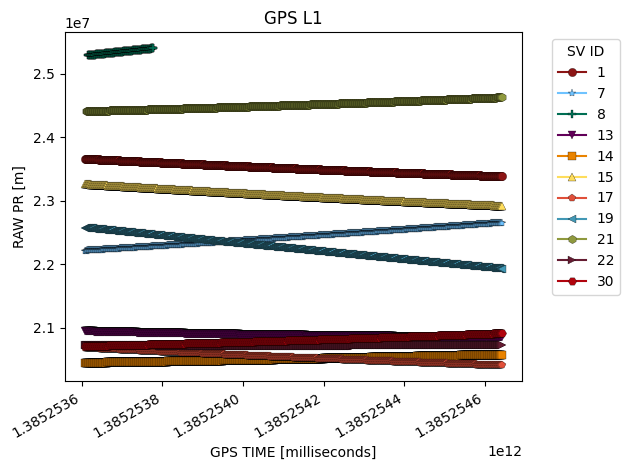

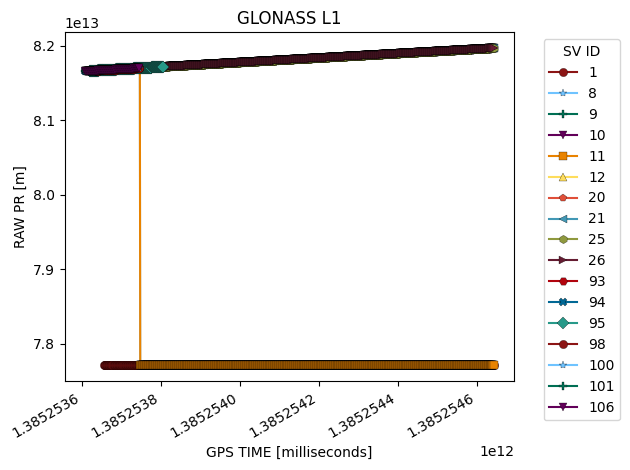

In [ ]:
figs = glp.plot_metric_by_constellation(raw_data.where("sv_id",2,"neq"),"gps_millis","raw_pr_m")

3.479709702887383
21693


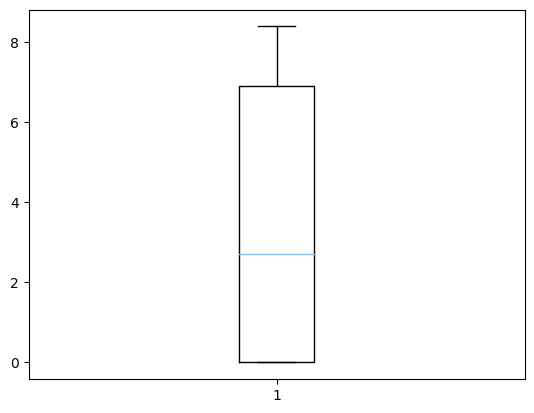

In [ ]:
print(np.mean(raw_data["raw_pr_sigma_m"]))
print(len(raw_data))
plt.boxplot(raw_data["raw_pr_sigma_m"])
plt.show()

Before we can compute a Weighted Least Squares position, we first need to add satellite positions to our data. This block may take a bit of time since it has to download ephemeris files from the internet. Turn on `verbose=True` to see the data sources it's downloading.

We can then compute a "corrected" pseudorange by subtracting out each satellite's respective clock bias.

In [ ]:
full_states["corr_pr_m"] = full_states["raw_pr_m"] \
                         + full_states['b_sv_m']

Since we haven't yet computed any inter-constellation bias, we will crop down to only using GPS and Galileo measurements since the inter-constellation bias between them and GLONASS is quite large in this instance.

In [ ]:
full_states = full_states.where("gnss_id",("gps","galileo"))

We can now calculate our Weighted Least Squares position estimate.

In [ ]:
wls_estimate = glp.solve_wls(full_states)

/content/lib/gnss_lib_py/gnss_lib_py/algorithms/snapshot.py:303: RuntimeWarning:

Newton Raphson did not converge.



Finally we'll plot our state estimate on a map.

In [ ]:
raw_fig = glp.plot_map(wls_estimate)
raw_fig.show()